In [148]:
import os
import sys
sys.path.append('/home/donal/PhD/spines/spine_nn/')

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import segmentation_models_pytorch as smp

from utils.customDataset_v2 import LabelDataset, k_fold_splitter
from argparse import ArgumentParser
import utils.LabellerTL as ltl

import dsntnn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [2]:
%matplotlib inline

In [132]:
batch_size=4
n_outputs = 13
learning_rate = 3e-3
num_epochs = 500
classifier=True
norm_coords=True
early_stopping=True

In [4]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

In [5]:
root_dir= '/data/PAB_data/vert_labelling/'
fold=1
mode='Training'

In [6]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9','T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

In [7]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

## Check inputs to model for labelling

Checking dataset + DSNT

In [125]:
train_transforms = A.Compose([#A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=20,
                                 shift_limit=0.1, p=1, border_mode=0),
            #A.GaussNoise(var_limit=0.025, p=0.5, per_channel=False),
            #A.Perspective(p=0.5),
            A.RandomCrop(height=342, width=512, p=0.5),
            A.Resize(height=512, width=512)
            ], 
        keypoint_params=A.KeypointParams(format=('yx'), label_fields=[
                                         'labels'], remove_invisible=False),
        additional_targets={'heatmap': 'mask'})

In [9]:
pre_processing_fn = smp.encoders.get_preprocessing_fn(
        ENCODER, ENCODER_WEIGHTS)

splitter = k_fold_splitter(root_dir, fold, mode, num_folds=4)

## Make dataloader

In [133]:
train, test = splitter.split_data()
# ** Create Dataset for training
train_dataset = LabelDataset(
    *train, pre_processing_fn=pre_processing_fn,
    transforms=train_transforms, normalise=True, classifier=classifier, 
    norm_coords=norm_coords)

train_generator = DataLoader(train_dataset, batch_size=batch_size)

Training: 220; Testing: 55


In [11]:
from einops import rearrange

In [12]:
cmap = sns.choose_cubehelix_palette(as_cmap=False)

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

In [66]:
def norm_img(img):
        if img.shape[-1] == 1:
            return (img-img.min())/(img.max()-img.min())
        elif img.shape[-1] == 3:
            norm_img = []
            for chan in np.arange(0, 3):
                norm_img.append(
                    (img[..., chan]-img[..., chan].min())/(img[..., chan].max()-img[..., chan].min()))
            return np.stack(norm_img, axis=-1)

def sharpen_heatmap(heatmap, alpha=2):
    sharp_map = heatmap ** alpha
    eps = 1e-24
    flat_map = sharp_map.flatten(2).sum(-1)[..., None, None]
    flat_map += eps
    return sharp_map/flat_map

In [136]:
def plot_heatmap(img, heatmap, apply_softmax=True, norm_coords=False, labels=None):
    #heatmap = sharpen_heatmap(heatmap, alpha=2)
    if apply_softmax:
            heatmap = dsntnn.flat_softmax(heatmap).cpu().numpy()
    else:
        heatmap = heatmap.cpu().numpy()
        
    idx=0
#     for channel in range(heatmap.shape[1]):
#         norm_map = heatmap[idx, channel]-heatmap[idx, channel].min()/ \
#                         (heatmap[idx, channel].max()-heatmap[idx, channel].min())
#         print(np.min(norm_map, axis=(-2, -1)))
#         heatmap[idx, channel] = norm_map
    cmap = sns.cubehelix_palette(start=0, rot=0.9, gamma=1, hue=0.8, as_cmap=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    img = rearrange(img, 'b c h w -> b h w c')
    plt_img = norm_img(img[idx].cpu().numpy())
    ax[0].imshow(plt_img, cmap='gray')
    
    # --- PLOT COORDINATES
    coords = dsntnn.dsnt(torch.tensor(heatmap), normalized_coordinates=norm_coords)
    print(labels)
    if norm_coords:
        coords = dsntnn.normalized_to_pixel_coordinates(coords, size=(512, 512))
    for channel in range(coords.shape[1]):
        x, y = coords[idx, channel]
        if channel == 0:
            continue
        if labels is not None and labels[idx, channel-1] == 1:
            vert = ordered_verts[channel-1]
            ax[0].scatter(x, y, s=20, c='r', marker='+')
            ax[0].text(x, y, vert, c='y', size=15)
            
    ## --- PLOT HEATMAP
    print('Min', np.min(heatmap[idx], axis=(-2,-1)))
    print('MAX', np.max(heatmap[idx], axis=(-2,-1)))
    ax[1].contourf(np.max(heatmap[idx], axis=0), cmap=cmap)
    ax[1].invert_yaxis()

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
Min [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
MAX [0.         0.         0.00636671 0.00624064 0.00636671 0.00636671
 0.00636671 0.00636671 0.00636671 0.00624064 0.00636671 0.
 0.         0.        ]


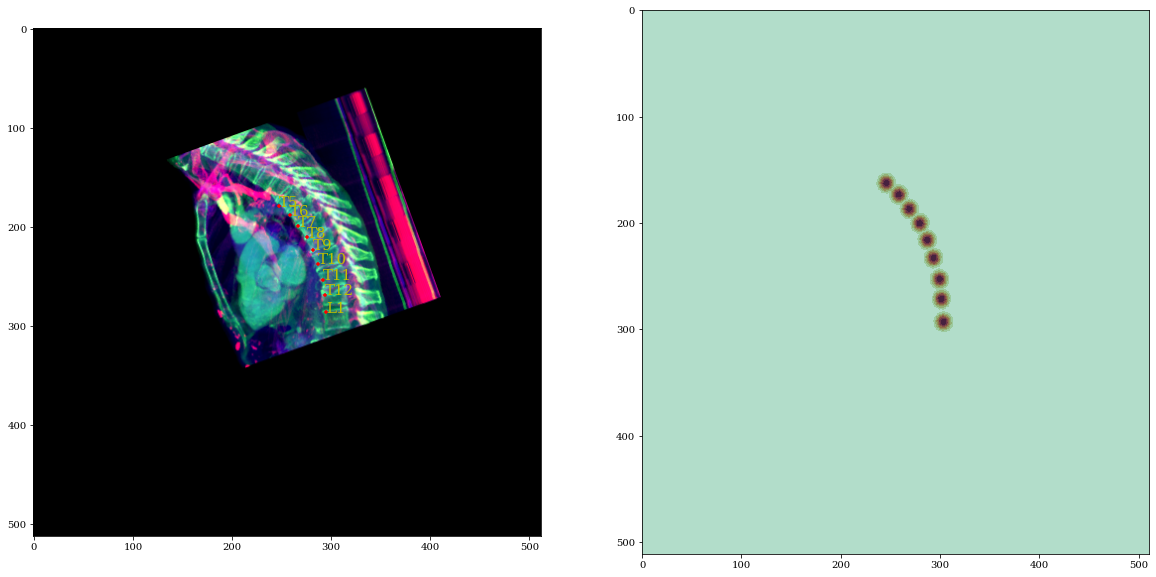

In [137]:
for data in train_generator:
    img = data['image'].to(device, dtype=torch.float32)
    heatmap = data['heatmap'].to(device, dtype=torch.float32)
    labels = data['labels'].to(device, dtype=torch.float32)
    
    plot_heatmap(img, heatmap, apply_softmax=False, norm_coords=True, labels=labels)
    break

### Check combination

In [154]:
from einops import rearrange

In [179]:
def check_combo(img, heatmap, mask, labels):
    idx= 1
    mask  = F.one_hot(mask, num_classes=14)
    mask = rearrange(mask, 'b h w c -> b c h w')
    map_ = mask * heatmap
    map_ = rearrange(map_[:, 1:], 'b c h w -> b c (h w)') #* Ignore background
    class_map = labels[..., None]*map_
    class_map = rearrange(class_map, 'b c (h w) -> b c h w', h=512, w=512)
    
    norm_map = F.relu(class_map)
    norm_map = sharpen_heatmap(norm_map, alpha=2)
    coords = dsntnn.dsnt(norm_map, normalized_coordinates=False)
    print(coords.shape)
    ## PLOTTING
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img = rearrange(img, 'b c h w -> b h w c')
    plt_img = norm_img(img[idx].cpu().numpy())
    ax.imshow(plt_img, cmap='gray')
    
    for i, vert in enumerate(ordered_verts):
        if labels[idx, i] == 0: continue
        x, y = coords[idx, i].cpu().numpy()
        
        ax.scatter(x, y, marker='+', c='r', s=15)
        ax.text(x, y, vert, c='r', size=15)
    
    return coords

torch.Size([4, 13, 2])


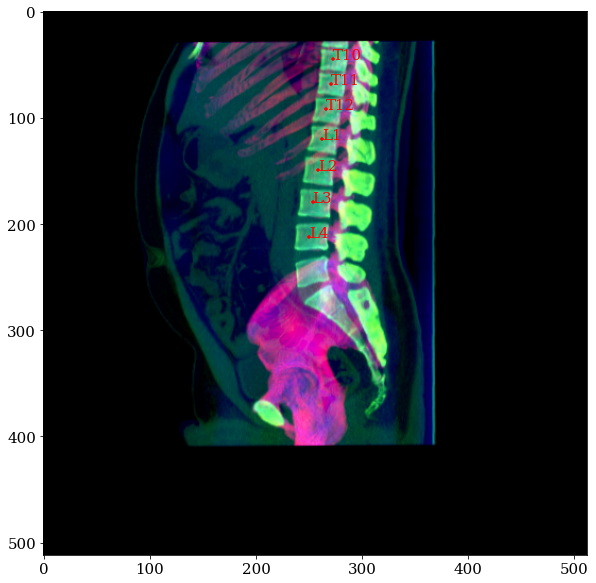

In [180]:
for data in train_generator:
    img = data['image'].to(device, dtype=torch.float32)
    points = data['keypoints'].to(device, dtype=torch.float32)
    heatmap = data['heatmap'].to(device, dtype=torch.float32)
    mask = data['mask'].to(device, dtype=torch.long)
    labels = data['labels'].to(device, dtype=torch.float32)
    coords = check_combo(img, heatmap, mask, labels)
    break